### Step 1 — Load Required Libraries

We import requests for the API call and pandas for handling time-series data.
This section focuses on retrieving and preparing the USD Index (DXY),
a major macroeconomic driver that influences commodity prices such as natural gas.

In [1]:
import requests, pandas as pd
import matplotlib.pyplot as plt

### Step 2 — Fetch USD Index (DXY) — Daily (FRED)

We pull the Broad USD Index from the FRED API, dataset ID: DTWEXBGS.
	•	Frequency: Daily
	•	Coverage: 2010-01-01 → Today
	•	Notes:
	•	You must insert your free FRED API key
	•	This series is widely used for macro-commodity modelling

In [4]:
START_DATE = "2010-01-01"

RAW_USD_CSV = "usd_index_01_01_10_raw.csv"
BIZ_USD_CSV = "usd_index_01_01_10_biz.csv"

FRED_URL = "https://api.stlouisfed.org/fred/series/observations"
SERIES_ID = "DTWEXBGS"  # Broad Dollar Index (Daily)
FRED_API_KEY = "6f5d3ad04e255cf7d9202581eef62a28"  # get free key at https://fred.stlouisfed.org/docs/api/api_key.html

def fetch_usd_index(start=START_DATE):
    params = {
        "series_id": SERIES_ID,
        "api_key": FRED_API_KEY,
        "file_type": "json",
        "observation_start": start
    }
    r = requests.get(FRED_URL, params=params, timeout=20)
    r.raise_for_status()

    obs = r.json()["observations"]
    df = pd.DataFrame(obs)
    df["date"] = pd.to_datetime(df["date"])
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    df = df[["date","value"]].rename(columns={"value":"usd_index"}).sort_values("date")
    return df

df_usd = fetch_usd_index()
df_usd.to_csv(RAW_USD_CSV, index=False)
df_usd.head(), df_usd.tail(), df_usd.shape

(        date  usd_index
 0 2010-01-01        NaN
 1 2010-01-04    92.3566
 2 2010-01-05    92.2236
 3 2010-01-06    92.0941
 4 2010-01-07    92.3684,
            date  usd_index
 4151 2025-12-01   121.3615
 4152 2025-12-02   121.5149
 4153 2025-12-03   121.1131
 4154 2025-12-04   121.0614
 4155 2025-12-05   121.0615,
 (4156, 2))

### Step 3 — Convert to Business Day Frequency

The USD index is not reported on weekends or certain holidays.
To align with your Henry Hub business-day series,
we generate a business-day index and forward-fill missing values.

This ensures:
	•	uniform spacing
	•	clean LSTM window creation
	•	no missing timesteps

In [5]:
df = pd.read_csv(RAW_USD_CSV, parse_dates=["date"]).sort_values("date")
df["usd_index"] = pd.to_numeric(df["usd_index"], errors="coerce")

# Build business-day index
bd = pd.DataFrame({"date": pd.bdate_range(df.date.min(), df.date.max())})

# Merge + forward-fill
df_biz = bd.merge(df, on="date", how="left").ffill()

df_biz.to_csv(BIZ_USD_CSV, index=False)
df_biz.head(), df_biz.tail(), df_biz.shape

(        date  usd_index
 0 2010-01-01        NaN
 1 2010-01-04    92.3566
 2 2010-01-05    92.2236
 3 2010-01-06    92.0941
 4 2010-01-07    92.3684,
            date  usd_index
 4151 2025-12-01   121.3615
 4152 2025-12-02   121.5149
 4153 2025-12-03   121.1131
 4154 2025-12-04   121.0614
 4155 2025-12-05   121.0615,
 (4156, 2))

### Step 4 — Visualise USD Index

Plot the cleaned, business-day-filled USD Index to confirm data integrity.

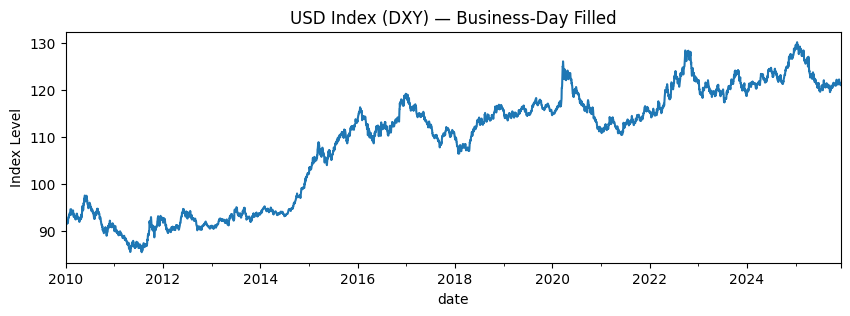

In [6]:
df_biz.set_index("date")["usd_index"].plot(figsize=(10,3))
plt.title("USD Index (DXY) — Business-Day Filled")
plt.ylabel("Index Level")
plt.show()